<a href="https://colab.research.google.com/github/itaewonflow/lecture-textmining-ml/blob/main/LDA_Gensim_Hangul.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- Itaewon flow github : https://github.com/itaewonflow
- Source Link : https://colab.research.google.com/github/itaewonflow/lecture-textmining-ml/blob/main/LDA_Gensim_Hangul.ipynb
- 마지막 작동 확인: 2023.11.16
---

## 0.사전설치: Konlpy 셋팅

In [1]:
# !curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash
!pip install konlpy

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#1.Data Loding

- Openpyxl을 이용하여 데이타를 Pandas에 넣는다.

In [2]:
excel_file = './02. 크롤링 결과_우울글 채택된 답글만.xlsx'

In [3]:
import pandas as pd
from openpyxl import load_workbook

column_name = []
column_sentence = []
load_ws = load_workbook(excel_file, data_only=True)
sheet_name = load_ws.active
load_ws = load_ws[sheet_name.title]

check_line = 1
for row in load_ws.rows:
    rows_list = []
    for cell in row:
        rows_list.append(cell.value)

    if check_line == 1:
        column_name.append(rows_list)
    else:
        column_sentence.append(rows_list)
    check_line = check_line + 1

##2.Text preprocessing process
- 전처리는 OKT를 사용하여 명사형만을 사용하는 것으로 진행
- OKT 실행 후 1글자는 제외 처리
- CountVectorize를 사용하여 사용량이 적은 단어를 제외처리한다.
- sentences_list 변수는 LDA에 활용하기 위함
- sentences_list_word 변수는 Gensim에 활용하기 위함

In [4]:
from konlpy.tag import Okt
Okt = Okt()

In [5]:
sentences_list = []
sentences_list_word = []
for key, value in enumerate(column_sentence):
    temp_noun = Okt.nouns(value[1])
    temp_noun = [token for token in temp_noun if len(token) > 1]

    sentences_list.append(" ".join(temp_noun))
    sentences_list_word.append(temp_noun)

In [6]:
sentences_list[1]

'말씀 아내 우울증 아내 우울증 우울증 슬픔 눈물 우울 불안 분노 짜증 무기 의욕 희망 흥미 식욕 변화 수면 변화 신체 아픔 생각 이상 개월 이상 지속 심리 장애 학업 인간관계 전반 부정 영향 심지어 생각 듭니 우울증 치료 말씀 우울증 확진 일단 우울증 심리 장애 심리검사 면담 여러 우울증 병원 진단 아내 부정 영향 걱정 우울증 치료 스스로 꼬리표 붙이 말씀 또한 오진 가능성 문의 우울증 갑상선 것일 가능성 조울증 가능성 정신과 염두 심리검사 다른 검사 면담 진일 가능성 우울증 마음 감기 심리 장애 또한 우울증 진단 삭제 우울증 경우 누군가 무어 해도 말씀 또한 우울증 때문 보험 보험 회사 문의 말씀 보험 회사 보험 우울증 문제 또한 아내 두통 우울증 진단 우울증 신체 정도 라면 성화 아내 정신과 우울증 꼬리 걱정 심리상담 우울증 심리상담 만성 라면 우울증 심리상담 우울증 심리상담 우울증 치료 아내 우울증 좌절 용기 내세 우울증 심리상담 저희 우울증 심리상담 전국 우울증 심리상담 요즘 우울증 사람 생각 우울증 정신병 그냥 마음 웰빙 생각 마음 심리 도움 생각 생각 아내 우울증 스스로 아내 심리상담 아내 심리상담 생각 심리상담 소의 심리상담 심리상담 능력 인지도 블로그 홈페이지 가장 마음 우울증 심리상담 아내 분도 우울증 어려움 극복 실수 질문 도움 도움 기억 질문 답변 심리 상담 직접 차이 문의 사항 아래 참고'

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(token_pattern="[\w']{3,}", max_features=2000, min_df=5, max_df=0.5)
sentences_cv = cv.fit_transform(sentences_list)

#3.LDA Loding

- max_iter를 8로 설정하면 알고리즘은 최대 8번의 반복을 수행합니다. 각 반복은 다음과 같은 단계로 구성됩니다:

- 초기화: 알고리즘은 토픽-단어 및 문서-토픽 분포를 초기화합니다. 이 초기화는 일반적으로 무작위로 이루어집니다.

- E 단계 (Expectation): 문서에 할당된 토픽을 바탕으로 각 단어의 토픽에 대한 기여도를 추정합니다. 이 단계에서는 단어의 토픽 기여도를 계산하기 위해 토픽-단어 및 문서-토픽 분포를 사용합니다.

- M 단계 (Maximization): E 단계에서 추정된 토픽 기여도를 바탕으로 토픽-단어 및 문서-토픽 분포를 업데이트합니다. 이 단계에서는 기여도를 최대화하는 방향으로 분포를 조정합니다.

- 수렴 확인: 알고리즘은 E 단계와 M 단계를 번갈아가며 수행하면서 반복적으로 토픽 분포를 업데이트합니다. 이때, max_iter 횟수만큼 반복을 수행하거나 더 이상 토픽 분포가 크게 변하지 않을 때까지 반복합니다.

In [14]:
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np

lda = LatentDirichletAllocation(n_components = 10, #추출할 topic의 수
                                max_iter=5,
                                topic_word_prior=0.1,
                                doc_topic_prior=1.0,
                                learning_method='online',
                                n_jobs= -1, #사용 processor 수
                                random_state=0)

sentence_topics = lda.fit_transform(sentences_cv)

In [10]:
print('\n#shape of Topics:', sentence_topics.shape)
print('\n#Sample of Topics:', sentence_topics[0])
print('\n#Sample of Topics:', sentence_topics[1])

gross_topic_weights = np.mean(sentence_topics, axis=0)
print('\n#Sum of topic weights of documents:', gross_topic_weights)
print('\n#shape of topic word distribution:', lda.components_.shape)
print('\n#shape of topic word distribution:', len(lda.components_[0]))


#shape of Topics: (1689, 10)

#Sample of Topics: [0.08333375 0.08418745 0.15759226 0.09132714 0.08335724 0.08334052
 0.08333381 0.08333377 0.08333407 0.16685999]

#Sample of Topics: [0.01831918 0.01596038 0.03201075 0.04018068 0.02273654 0.03258127
 0.01992118 0.01515499 0.0148666  0.78826844]

#Sum of topic weights of documents: [0.09821408 0.08696488 0.08891185 0.10191983 0.09031381 0.10315966
 0.0991304  0.12311231 0.08823359 0.12003958]

#shape of topic word distribution: (10, 584)

#shape of topic word distribution: 584


### 결과해설
- Topics의 (2,10)의 의미는 행은 각 문서 그대로, 열의 값들은 LDA가 추출한 토픽의 비중
- 즉, LDA변환결과는 각 문서별로 토픽분포를 보여준다

- Topics의 첫째행을 출력하면 첫 문서의 각 토픽에 대한 분포를 볼 수 있다
- numpy로 열에 대해 총합을 구하면 문서 전체에 나타난 토픽의 평균 분포를 알 수 있다. 즉 말뭉치 전체에서는 3번째 토픽이 83.8%로 가장 많이 나타난다.

- lda.components_의 shape을 출력해보면 (10,17)이 나오는데, 이는 각 토픽에 대해 카운트 벡터에서 사용한 단어 2,000개의 비중을 표현하기 때문이다.

In [11]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d: " % topic_idx, end='')
        print(", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
        # 위 slicing에서 맨 뒤 -1은 역순을 의미, 역순으로 했을 때 처음부터 n_top_words까지

print_top_words(lda, cv.get_feature_names_out(), 20)

Topic #0: 공황장애, 스스로, 불안장애, 스트레스, 세로토닌, 정신과, 대부분, 심리학, 제대로, 강박증, 마음대로, 절대로, 연구소, 두려움, 갑자기, 시스템, 뇌신경, 공포증, 불안감, 분노조절
Topic #1: 스트레스, 따라서, 치료법, 알코올, 보험사, 한의원, 고혈압, 대부분, 비타민, 오히려, 보험금, 수면제, 편두통, 컴퓨터, 신경계, 스스로, 정신과, 진통제, 가능성, 불면증
Topic #2: 우울증, 우울함, 바르게, 정신병, 자존감, 전문가, 반드시, 신경증, 스스로, 인지부조화, 대부분, 아버지, 일상생활, 어머니, 하나님, 죄책감, 기면증, 두려움, 갑자기, 무의식
Topic #3: 부작용, 정신건강, 정신과, 정신질환, 저절로, 의학과, 병무청, 정신병원, 우울증, 마지막, 조현병, 심리검사, 따라서, 이야기, 정신의학, 보호자, 여러분, 처방전, 서비스, 억지로
Topic #4: 우울증, 작성자, 스스로, 자율신경, 세로토닌, 얼마나, 정신과, 갈수록, 장기간, 불안감, 신경증, 소화기, 누군가, 화이팅, 무의식, 전문가, 토닥토닥, 에너지, 때로는, 이야기
Topic #5: 부모님, 선생님, 이야기, 청소년, 정신과, 어려움, 우울증, 상담사, 최대한, 마인드, 트라우마, 가능성, 주치의, 인터넷, 유튜브, 자격증, 스스로, 마지막, 크리에이터, 사이버
Topic #6: 심리치료, 우울증, 불안장애, 정신과, 불면증, 스트레스, 성공사례, 마음상태, 자신감, 심리상담, 항우울제, 부작용, 전문가, 신경안정제, 스스로, 인간관계, 사고방식, 어려움, 뇌신경, 공황장애
Topic #7: 전문가, 신경증, 정신과, 전문의, 후유증, 위험성, 정신장애, 정신장애인, 노이로제, 정신분열증, 현대인, 정밀검사, 의약품, 얼마나, 이박사, 이규태, 네이버, 향정신성의약품, 정신건강, 불가능
Topic #8: 어지럼증, 스트레스, 브레인, 자위행위, 어지러움, 대부분, 네이버, 성행위, 스스로, 우울증, 갑자기, 이성준, 무기력증, 무언가

- 가장 많이 언급된 단어들을 보기 위해서는 위와 같다.

##4. Optimal Setting for Topic Modeling

- 토픽모델링에서 가장 중요한 하이퍼 파라미터는 바로 토픽의 수
- 이를 위해 다양한 혼란도와 토픽 응집도를 계산하는 방법 존재
- 사이킷런은 혼란도만 공식적으로 제공 / 혼란도는 작을수록 좋다

n_components: 5, perplexity: 16.677
n_components: 6, perplexity: 17.337
n_components: 7, perplexity: 17.906
n_components: 8, perplexity: 18.409
n_components: 9, perplexity: 18.867
n_components: 10, perplexity: 19.294
n_components: 11, perplexity: 19.695
n_components: 12, perplexity: 20.078
n_components: 13, perplexity: 20.447
n_components: 14, perplexity: 20.805
n_components: 15, perplexity: 21.153


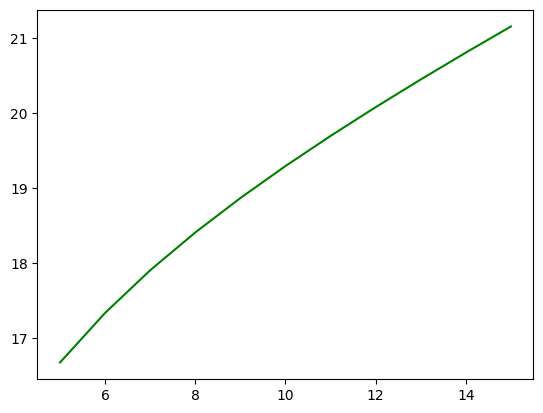

n_components with minimum perplexity: 5


In [12]:
import matplotlib.pyplot as plt

def show_perplexity(cv, start=10, end=30, max_iter=5, topic_word_prior= 0.1,
                    doc_topic_prior=1.0):
    iter_num = []
    per_value = []

    for i in range(start, end + 1):
        lda = LatentDirichletAllocation(n_components = i, max_iter=max_iter,
                                        topic_word_prior= topic_word_prior,
                                        doc_topic_prior=doc_topic_prior,
                                        learning_method='batch', n_jobs= -1,
                                        random_state=7)
        lda.fit(cv)
        iter_num.append(i)
        pv = lda.perplexity(cv)
        per_value.append(pv)
        print(f'n_components: {i}, perplexity: {pv:0.3f}')

    plt.plot(iter_num, per_value, 'g-')
    plt.show()
    return start + per_value.index(min(per_value))

print("n_components with minimum perplexity:",
      show_perplexity(sentence_topics, start=5, end=15))

- 상기 나온 최저점의 혼잡도를 선정한다.
- 하지만 상기 그래프를 확인하면, 동일한 주제의 크롤링 데이타인 관계로 적정선의 혼잡도를 잡기 어려운 상황 - 5로 셋팅한다.

In [15]:
lda = LatentDirichletAllocation(n_components = 5,
                                max_iter=20,
                                topic_word_prior= 0.1,
                                doc_topic_prior=1.0,
                                learning_method='batch',
                                n_jobs= -1,
                                random_state=7)

review_topics = lda.fit_transform(sentence_topics)
print_top_words(lda, cv.get_feature_names_out(), 10)

Topic #0: 가쁘거, 가위눌림, 가정의학, 가까이, 가족사, 가운데, 간호사, 가르침, 가능성, 가정폭력
Topic #1: 간호사, 가까이, 가르침, 가정폭력, 가운데, 가위눌림, 가쁘거, 가능성, 가족사, 가정의학
Topic #2: 가정의학, 가정폭력, 간호사, 가위눌림, 가까이, 가쁘거, 가운데, 가능성, 가르침, 가족사
Topic #3: 간호사, 가능성, 가족사, 가르침, 가정의학, 가위눌림, 가쁘거, 가운데, 가까이, 가정폭력
Topic #4: 가정폭력, 가족사, 가르침, 간호사, 가능성, 가쁘거, 가운데, 가위눌림, 가정의학, 가까이


# 5.Gensim Topic Modeling

-Gensim은 Word2Vec으로 잘 알려져 있으며, 토픽 모델링을 비롯해 의미적인 자연어 처리를 위한 다양한 라이브러리를 제공한다.

In [16]:
!pip install --upgrade gensim

In [23]:
sentences_list_word[0]

['좀더',
 '진행',
 '누가',
 '정신병',
 '진행',
 '느낌',
 '시간',
 '헤프',
 '영화',
 '에피소드',
 '애메',
 '신경',
 '기우']

### 순서확인기

- Gensim은 먼저 토큰화 결과로부터 토큰과 gendim모듈이 내부적으로 사용하는 id를 매칭하는 사전을 생성 -> Dictionary 클래스 사용
- filter_extremes() 메소드에서, 사이킷런의 max_features에 해당하는 keep_n인수, min_df에 해당하는 no_below, max_df에 해당하는 no_above인수를 이용해 특성을 선택
- doc2bow()메소드로 토큰화된 결과를 카운트 벡터, 즉 BOW형태로 변환

- Gensim에서 LDA 모델을 수행하는 클래스인 LdaModel 시행
- num_topics : 토픽의 수
- id2word : Dictionary를 의미
- passes : 사이킷런의 max_iter와 같다고 보면 됨, 학습하는 횟수를 지정한다.


In [17]:
from gensim.corpora.dictionary import Dictionary

# 토큰화 결과로부터 dictionay 생성
dictionary = Dictionary(sentences_list_word)
print('#Number of initial unique words in documents:', len(dictionary))

# 문서 빈도수가 너무 적거나 높은 단어를 필터링하고 특성을 단어의 빈도 순으로 선택
dictionary.filter_extremes(keep_n=2000, no_below=5, no_above=0.5)
print('#Number of unique words after removing rare and common words:', len(dictionary))

# 카운트 벡터로 변환
corpus = [dictionary.doc2bow(text) for text in sentences_list_word]
print('#Number of unique tokens: %d' % len(dictionary))
print('#Number of documents: %d' % len(corpus))

#Number of initial unique words in documents: 8283
#Number of unique words after removing rare and common words: 2000
#Number of unique tokens: 2000
#Number of documents: 1689


- Gensim에서 LDA 모델을 수행하는 클래스인 LdaModel 시행
- num_topics : 토픽의 수
- id2word : Dictionary를 의미
- passes : 사이킷런의 max_iter와 같다고 보면 됨, 학습하는 횟수를 지정한다.

In [18]:
from gensim.models import LdaModel

num_topics = 10
passes = 5
%time model = LdaModel(corpus=corpus,id2word=dictionary,passes=passes,num_topics=num_topics,random_state=7)

CPU times: user 6.69 s, sys: 117 ms, total: 6.81 s
Wall time: 6.78 s


In [19]:
model.print_topics(num_words=10)

[(0,
  '0.081*"치료" + 0.070*"증상" + 0.050*"완치" + 0.043*"정신" + 0.028*"적극" + 0.025*"상태" + 0.020*"신경증" + 0.018*"사실" + 0.016*"정신과" + 0.014*"정신분열증"'),
 (1,
  '0.028*"질문" + 0.017*"생각" + 0.017*"사람" + 0.016*"보험" + 0.014*"우울증" + 0.014*"지금" + 0.010*"가입" + 0.009*"친구" + 0.009*"상담" + 0.008*"치료"'),
 (2,
  '0.042*"심리치료" + 0.040*"약물" + 0.040*"원인" + 0.039*"마음" + 0.037*"치료" + 0.032*"문제" + 0.030*"우울증" + 0.025*"우울" + 0.022*"증상" + 0.021*"심리"'),
 (3,
  '0.032*"두통" + 0.018*"경우" + 0.017*"혈액" + 0.017*"증상" + 0.016*"순환" + 0.015*"사람" + 0.013*"운동" + 0.012*"통증" + 0.010*"효과" + 0.010*"머리"'),
 (4,
  '0.074*"증상" + 0.069*"치료" + 0.035*"정신" + 0.034*"심리" + 0.033*"완치" + 0.028*"신경증" + 0.026*"복용" + 0.026*"전문가" + 0.024*"적극" + 0.021*"검사"'),
 (5,
  '0.036*"치료" + 0.034*"상담" + 0.026*"우울증" + 0.020*"약물" + 0.017*"심리상담" + 0.013*"증상" + 0.012*"센터" + 0.011*"마음" + 0.011*"심리치료" + 0.011*"도움"'),
 (6,
  '0.032*"마음" + 0.023*"우울증" + 0.022*"생각" + 0.017*"자신" + 0.015*"증상" + 0.015*"치료" + 0.013*"사람" + 0.010*"인지" + 0.009*"불안" + 0.008*"질문"'),
 (7,
  '0.

- 숫자는 각 토픽으로 분류될 때 단어들의 기여도

- get_document_topics 메소드를 이용하면 인수로 넘긴 무너들에 대해 토픽 분포를 반환한다. 즉 인수로 corpus - BOW로 변환된 카운트 벡터를 요구하며, minimum_probability로 보여질 토픽의 비중에 대한 임계값을 설정할 수 있다.

In [20]:
print("#topic distribution of the first document: ", model.get_document_topics(corpus)[0])

#topic distribution of the first document:  [(0, 0.0100023225), (1, 0.010004489), (2, 0.01000297), (3, 0.010003405), (4, 0.010002463), (5, 0.30072388), (6, 0.61924183), (7, 0.010006203), (8, 0.010006986), (9, 0.010005418)]


In [21]:
!pip install pyLDAvis

In [24]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# feed the LDA model into the pyLDAvis instance
lda_viz = gensimvis.prepare(model, corpus, dictionary)
lda_viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.092258 -0.068584       1        1  20.613083
2      0.032146 -0.115782       2        1  12.675917
7      0.037207  0.096069       3        1  11.772443
9      0.024144  0.049207       4        1  11.215777
8      0.091042 -0.134780       5        1  10.981295
5      0.021124 -0.027081       6        1   9.744624
1      0.105416  0.005927       7        1   7.808010
3      0.106786  0.187921       8        1   6.716804
4     -0.277122  0.020575       9        1   5.159882
0     -0.233002 -0.013472      10        1   3.312164, topic_info=    Term         Freq        Total Category  logprob  loglift
93    치료  4402.000000  4402.000000  Default  30.0000  30.0000
130   증상  4090.000000  4090.000000  Default  29.0000  29.0000
32    마음  4008.000000  4008.000000  Default  28.0000  28.0000
129   완치   966.000000   966.000000  Default  27.0000  27.0000
295   정신  1375.000000  1375.000000  Default  26.0000  26.0000
..   ...          ...          ...      ...      ...      ...
14    검사    42.275263   735.261729  Topic10  -4.9818   0.5515
32    마음    49.150875  4008.069209  Topic10  -4.8311  -0.9936
49    상담    44.526996  1421.834839  Topic10  -4.9299  -0.0560
343   현재    39.065473   540.155101  Topic10  -5.0608   0.7810
46    사람    40.439625  2203.068901  Topic10  -5.0262  -0.5902

[720 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
999       1  0.014049    가능
999       2  0.014049    가능
999       3  0.028099    가능
999       4  0.238838    가능
999       5  0.014049    가능
...     ...       ...   ...
847      10  0.080892   흥분제
1656      3  0.070336  히스테리
1656      4  0.281343  히스테리
1656      9  0.211007  히스테리
1656     10  0.422014  히스테리

[3021 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 3, 8, 10, 9, 6, 2, 4, 5, 1])

- 응집도를 구하는 방법

In [25]:
from gensim.models import CoherenceModel

cm = CoherenceModel(model=model, corpus=corpus, coherence='u_mass')
coherence = cm.get_coherence()
print(coherence)

-1.0671188358391395


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


num_topics: 6, perplexity: -6.378, coherence: -0.984


num_topics: 7, perplexity: -6.375, coherence: -1.147


num_topics: 8, perplexity: -6.371, coherence: -0.997


num_topics: 9, perplexity: -6.359, coherence: -1.077


num_topics: 10, perplexity: -6.391, coherence: -1.137


num_topics: 11, perplexity: -6.332, coherence: -1.032


num_topics: 12, perplexity: -6.342, coherence: -1.343


num_topics: 13, perplexity: -6.367, coherence: -1.160


num_topics: 14, perplexity: -6.375, coherence: -1.120
num_topics: 15, perplexity: -6.357, coherence: -1.192


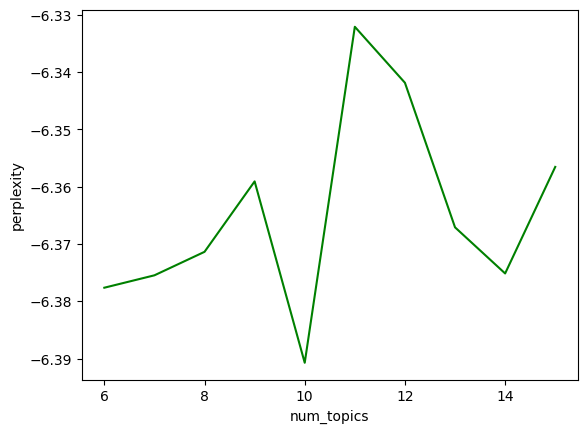

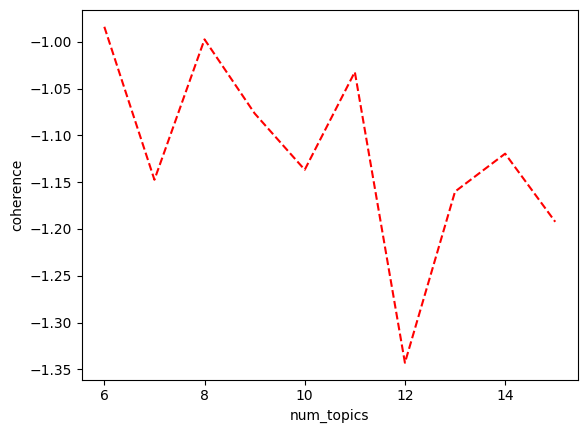

In [26]:
def show_coherence(corpus, dictionary, start=6, end=15):
    iter_num = []
    per_value = []
    coh_value = []

    for i in range(start, end + 1):
        model = LdaModel(corpus=corpus, id2word=dictionary,
                 chunksize=1000, num_topics=i,
                 random_state=7)
        iter_num.append(i)
        pv = model.log_perplexity(corpus)
        per_value.append(pv)

        cm = CoherenceModel(model=model, corpus=corpus,
                            coherence='u_mass')
        cv = cm.get_coherence()
        coh_value.append(cv)
        print(f'num_topics: {i}, perplexity: {pv:0.3f}, coherence: {cv:0.3f}')

    plt.plot(iter_num, per_value, 'g-')
    plt.xlabel("num_topics")
    plt.ylabel("perplexity")
    plt.show()

    plt.plot(iter_num, coh_value, 'r--')
    plt.xlabel("num_topics")
    plt.ylabel("coherence")
    plt.show()

show_coherence(corpus, dictionary, start=6, end=15)